In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pyampd import ampd
import scipy.signal as signal
import scipy.ndimage as ndimage
from scipy.signal import ShortTimeFFT, windows


def db(x):
    return 10 * np.log10(x)

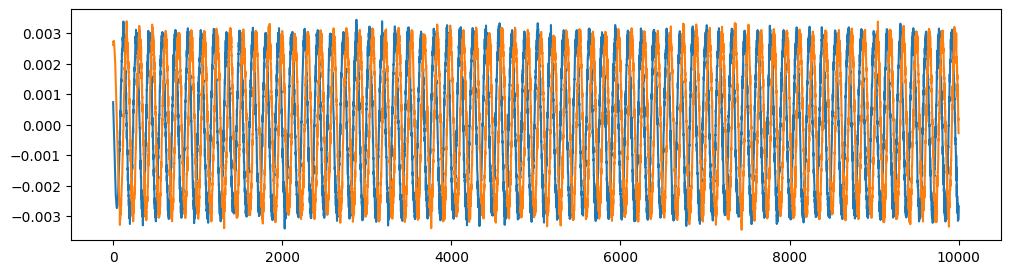

In [3]:
# load raw samples
d = np.fromfile("../data/test_windows.fc32", dtype=np.complex64)
fs = 768000  # sampling frequency
_samples = d[:10_000]
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(np.real(_samples))
ax.plot(np.imag(_samples))

In [5]:
%%time
# perform FFT over sliding window, and convert to dB
window_size = 1024 * 5
SFT = ShortTimeFFT(win=np.ones(window_size), hop=window_size, fs=fs, fft_mode="centered")
D = SFT.stft(d)
PSD = np.abs(D)**2
P = db(PSD)
# we can try slightly different ways to compute and subtract the noise floor
# baseline = np.mean(P, axis=0, keepdims=True)
# baseline = ndimage.uniform_filter1d(P, size=100_000, axis=1, mode="constant", cval=0)
baseline = np.cumsum(P, axis=1) / np.arange(1, P.shape[1] + 1)
P_adj = P - baseline

CPU times: total: 2.2 s
Wall time: 2.83 s


In [6]:
P.shape[0]

5120

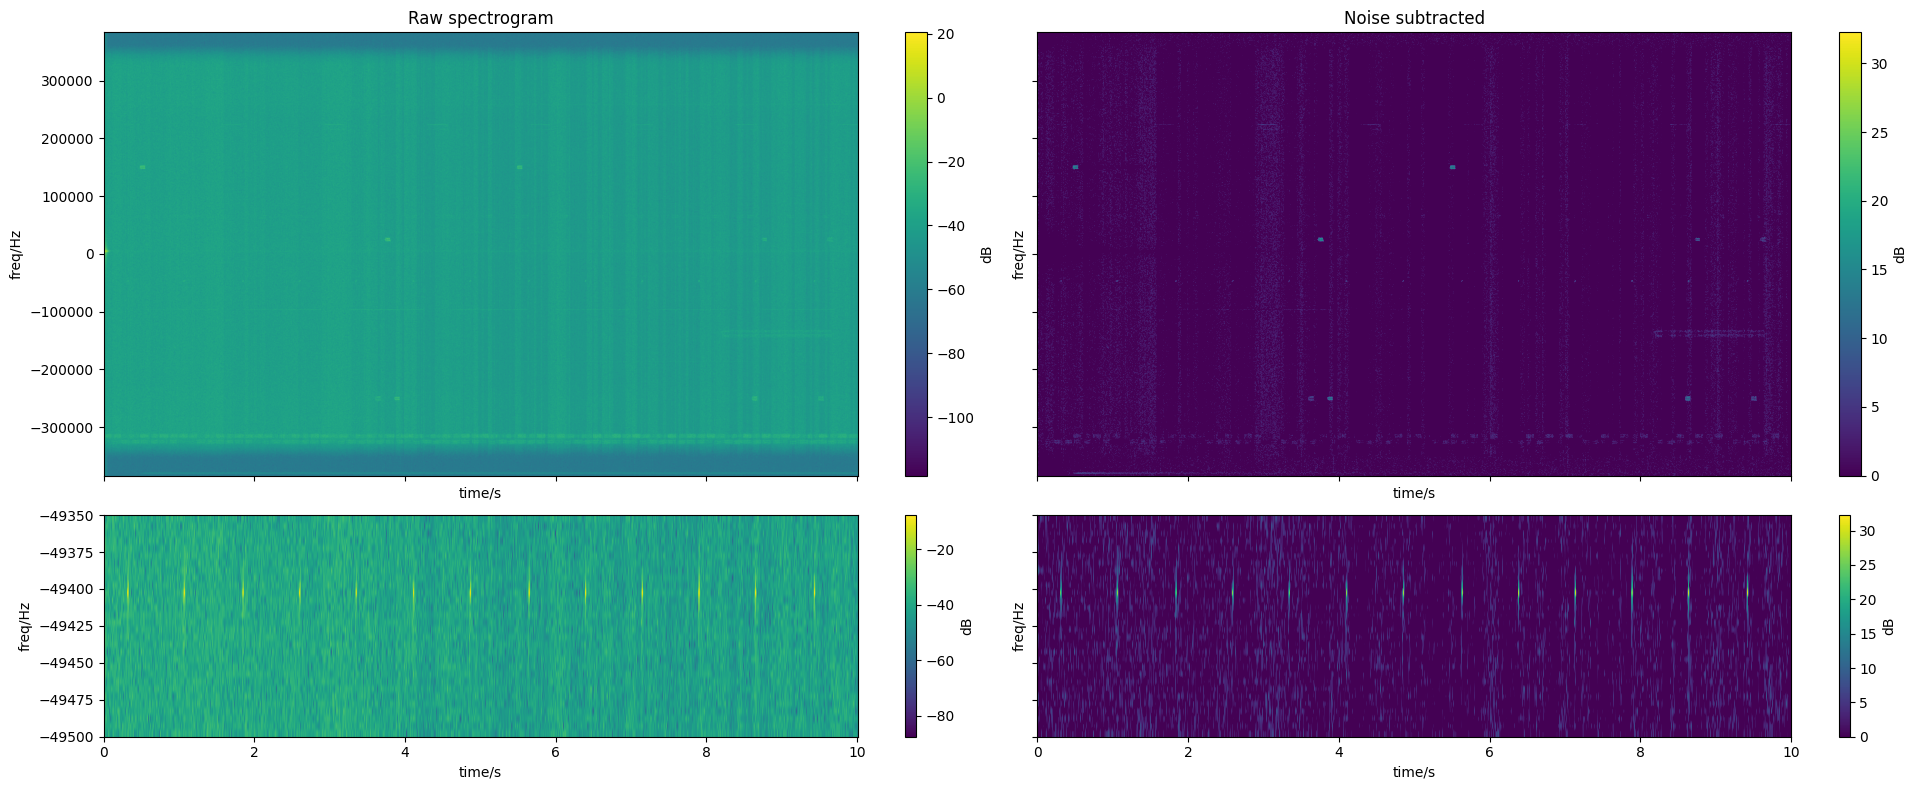

In [8]:
extent_full = t0, t1, f0, f1 = SFT.extent(len(d))
_slice = slice(2230, 2260)
f_slice = np.linspace(f0, f1, num=P.shape[0])
f2, f3 = f_slice[_slice][0], f_slice[_slice][1]
extent_slice = (t0, t1, f2, f3)
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=2, sharex=True, sharey="row", height_ratios=[2,1])
ax = axes[0][0]
im = ax.imshow(
    P,
    aspect="auto",
    origin="lower",
    extent=extent_full,
)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")
ax.set_title("Raw spectrogram")

ax = axes[0][1]
im = ax.imshow(
    P_adj,
    aspect="auto",
    origin="lower",
    extent=SFT.extent(len(d)),
    vmin=0,
)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")
ax.set_title("Noise subtracted")
plt.tight_layout()

ax = axes[1][0]
im = ax.imshow(P[_slice], aspect="auto", origin="lower", extent=extent_slice)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")

ax = axes[1][1]
im = ax.imshow(
    P_adj[_slice],
    aspect="auto",
    origin="lower",
    vmin=0,
    extent=extent_slice
)
fig.colorbar(im, label="dB", ax=ax)
ax.set_xlabel("time/s")
ax.set_ylabel("freq/Hz")
plt.tight_layout()

CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 46.9 ms
Wall time: 71.5 ms


Text(0.5, 1.0, 'Average of manually selected frequency band')

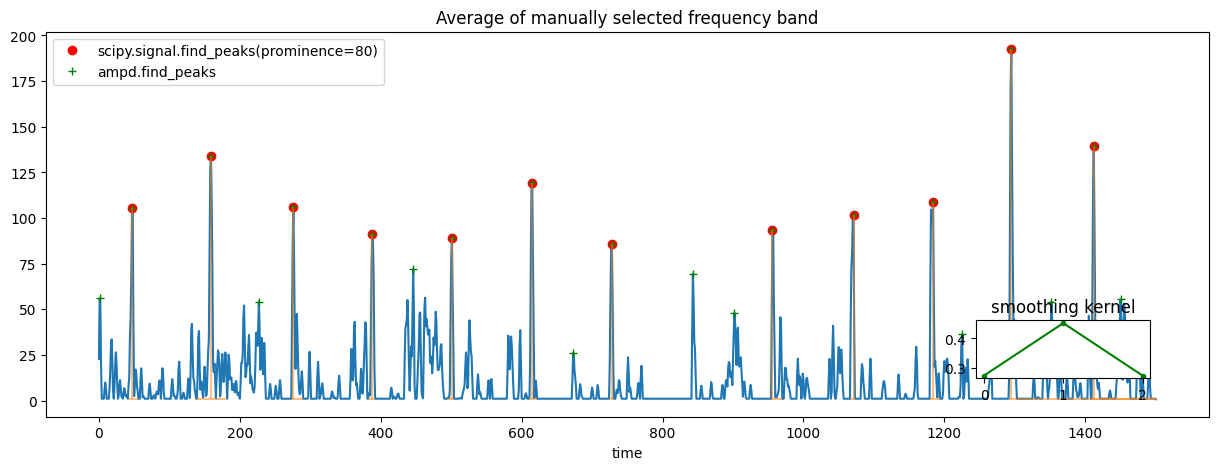

In [9]:
# for now, I am manually selecting an interesting slice (see above) to find the time indices of interesting peaks
section = section_raw = np.clip(P_adj[_slice].sum(axis=0), 1, None)
kernel = windows.gaussian(3, 1)
kernel /= kernel.sum()
section = np.convolve(section, kernel, mode="same")
prominence = 80
%time peak_idx, peak_props = signal.find_peaks(section, prominence=prominence)
%time ampd_idx = ampd.find_peaks(section, scale=None)
time_peak_idx = peak_idx
fig, ax = plt.subplots(figsize=(15, 5))
t = np.arange(len(section))
# ax.plot(t, section_raw, alpha=0.1)
ax.plot(t, section)
ax.plot(t[peak_idx], section[peak_idx], "ro", label=f"scipy.signal.find_peaks({prominence=})")
ax.plot(t[ampd_idx], section[ampd_idx], "g+", label="ampd.find_peaks")
ax.legend()
ax.vlines(
    x=t[peak_idx], ymin=section[peak_idx] - peak_props["prominences"], ymax=section[peak_idx], color="C1", alpha=0.5
)
ax.hlines(
    y=section[peak_idx] - peak_props["prominences"],
    xmin=peak_props["left_bases"],
    xmax=peak_props["right_bases"],
    color="C1",
    alpha=0.5,
)
ax.set_xlabel("time")
axin = ax.inset_axes([0.8, 0.1, 0.15, 0.15])
axin.plot(kernel, "g.-")
axin.set_title("smoothing kernel")
ax.set_title("Average of manually selected frequency band")

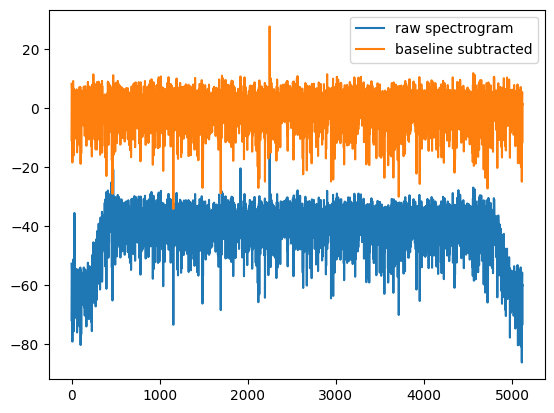

In [12]:
# compare adjusted and unadjusted spectrum at one time location
time_idx = time_peak_idx[4]
plt.plot(P[:, time_idx], label="raw spectrogram")
plt.plot(P_adj[:, time_idx], label="baseline subtracted")
plt.legend()

CPU times: user 148 μs, sys: 147 μs, total: 295 μs
Wall time: 139 μs
CPU times: user 17.1 ms, sys: 816 μs, total: 17.9 ms
Wall time: 17.2 ms


KeyError: 'prominences'

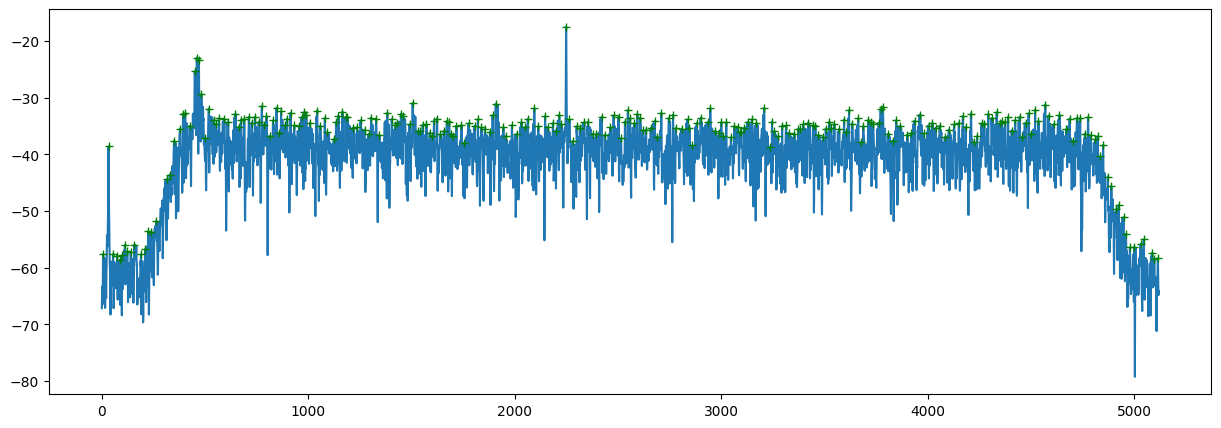

In [422]:
section_raw = P[:, time_peak_idx[1]]
section = section_raw
kernel = windows.gaussian(3, 1)
# kernel -= kernel.mean()
kernel /= np.abs(kernel).sum()
section = np.convolve(section, kernel, mode="valid")
height=10
%time peak_idx, peak_props = signal.find_peaks(section, height=height)
%time ampd_idx = ampd.find_peaks(section, scale=None)
fig, ax = plt.subplots(figsize=(15, 5))
t = np.arange(len(section))
# ax.plot(t, section_raw, alpha=0.1)
ax.plot(t, section)
ax.plot(t[peak_idx], section[peak_idx], "ro", label=f"scipy.signal.find_peaks({prominence=})")
ax.plot(t[ampd_idx], section[ampd_idx], "g+", label="ampd.find_peaks")
ax.vlines(
    x=t[peak_idx],
    ymin=section[peak_idx] - peak_props["prominences"],
    ymax=section[peak_idx],
    color="C1",
    alpha=0.5,
)
ax.hlines(
    y=section[peak_idx] - peak_props["prominences"],
    xmin=peak_props["left_bases"],
    xmax=peak_props["right_bases"],
    color="C1",
    alpha=0.5,
)
ax.legend()
ax.set_xlabel("freq")
axin = ax.inset_axes([0.8, 0.1, 0.15, 0.15])
axin.plot(kernel, "go-")
axin.set_title("smoothing kernel")
ax.set_title("Spectrum at single timestamp")

CPU times: user 65 μs, sys: 12 μs, total: 77 μs
Wall time: 68.9 μs
CPU times: user 921 μs, sys: 221 μs, total: 1.14 ms
Wall time: 941 μs


Text(0.5, 1.0, 'Spectrum at single timestamp')

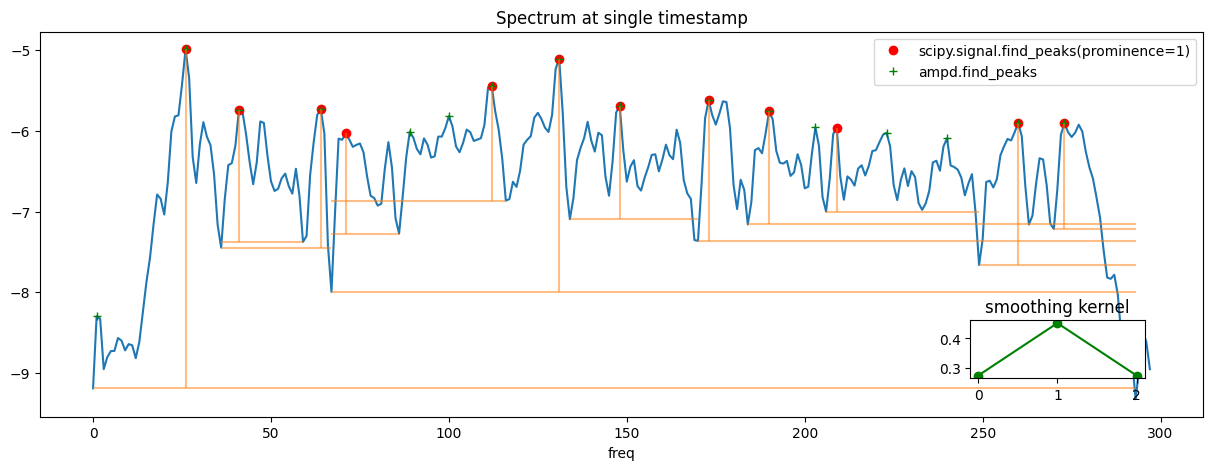

In [360]:
section_raw = P_raw[:, time_peak_idx[5]]
section = section_raw
kernel = windows.gaussian(3, 1)
# kernel -= kernel.mean()
kernel /= np.abs(kernel).sum()
section = np.convolve(section, kernel, mode="valid")
prominence=1
%time peak_idx, peak_props = signal.find_peaks(section, prominence=prominence)
%time ampd_idx = ampd.find_peaks(section, scale=None)
fig, ax = plt.subplots(figsize=(15, 5))
t = np.arange(len(section))
# ax.plot(t, section_raw, alpha=0.1)
ax.plot(t, section)
ax.plot(t[peak_idx], section[peak_idx], "ro", label=f"scipy.signal.find_peaks({prominence=})")
ax.plot(t[ampd_idx], section[ampd_idx], "g+", label="ampd.find_peaks")
ax.vlines(
    x=t[peak_idx],
    ymin=section[peak_idx] - peak_props["prominences"],
    ymax=section[peak_idx],
    color="C1",
    alpha=0.5,
)
ax.hlines(
    y=section[peak_idx] - peak_props["prominences"],
    xmin=peak_props["left_bases"],
    xmax=peak_props["right_bases"],
    color="C1",
    alpha=0.5,
)
ax.legend()
ax.set_xlabel("freq")
axin = ax.inset_axes([0.8, 0.1, 0.15, 0.15])
axin.plot(kernel, "go-")
axin.set_title("smoothing kernel")
ax.set_title("Spectrum at single timestamp")